# featureCounts Compare Genome vs Transcriptome for non DMS samples: Madrasin + Controls

## Purpose

This were read counts generated by the program featureCounts After STAR alignment

Aim of this script is to get the ratio of Genomic reads to Transcriptomic reads for samples that were not treated with DMS 

We want to see how the ratio changes as you add varying concentrations of Madrasin

In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

In [2]:
# Load R GGplots
%load_ext rpy2.ipython
%R require(ggplot2)
%R require(reshape)

/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: reshape

  warnings.warn(x, RRuntimeWarning)


array([1], dtype=int32)

In [3]:
# Set variable to find highly expressed genes or transcripts
feature="Gene"

In [4]:
# Set variable to remove non-coding genes
removeNC=False
removeNC_string=""
if removeNC:
    removeNC_string="Coding"
    geneNamesAndTranscriptIDs = pd.read_csv("../data/GeneNameTranscriptID_NCBI_RefSeq_hg38_FromGFFfile.tsv",header=None,sep="\t")
    noncodinggeneNames= list(geneNamesAndTranscriptIDs[geneNamesAndTranscriptIDs[0].str.contains("NR_")|geneNamesAndTranscriptIDs[0].str.contains("XR_")][1].values)
    noncodingtranscriptNames= list(geneNamesAndTranscriptIDs[geneNamesAndTranscriptIDs[0].str.contains("NR_")|geneNamesAndTranscriptIDs[0].str.contains("XR_")][0].values)
    noncodingFeatures = noncodinggeneNames+noncodingtranscriptNames

In [5]:
# Set variable to only look at features that have introns in them
featuresWithIntrons=True
featuresWithIntrons_string=""
if featuresWithIntrons:
    featuresWithIntrons_string="WithIntronicRegions"
    # Get the transcript and genes that have introns within them
    geneNamesAndTranscriptIDs_withIntrons = pd.read_csv("../data/GeneNameTranscriptID_NCBI_RefSeq_hg38_FromGFFfile_OnlyOnesWithIntrons.tsv",header=None,sep="\t")
    print geneNamesAndTranscriptIDs_withIntrons.shape
    geneNamesAndTranscriptIDs_withIntrons.head()

(153118, 2)


In [6]:
# Set variable to determine how many expressed features to look at
# If set to 0, then get all features
numFeatures=50

In [7]:
# Get highly expressed features from each file for the transcriptome data
top_features_Transcriptome = []
for filename in os.listdir("../tmp/Lela_MadrasinReadsTest_June2018/"):
    if ("Transcriptome_featureCounts_JustCounts.txt" in filename) and (("minus" in filename and "Mad-30mm-8hr-minus" not in filename) or ("Mad-30mm-8hr-DMS" in filename) or ("All_Minus" in filename)):
        print filename
        # Read the salmon output file
        with open("../tmp/Lela_MadrasinReadsTest_June2018/"+filename) as f:
            lines = f.readlines()
        with open("../tmp/Lela_MadrasinReadsTest_June2018/"+filename.split('.')[0]+"_DropHeader.txt",'w') as fw:
            fw.writelines(lines[1:])
        data_to_read = pd.read_csv("../tmp/Lela_MadrasinReadsTest_June2018/"+filename.split('.')[0]+"_DropHeader.txt",header=0,sep="\t")
        data_to_read.columns = ["Name","Length","Count"]
        # If features with Introns flag is set, only get features that have introns in them
        if featuresWithIntrons:
            # Only features with introns
            data_to_read = data_to_read[(data_to_read["Name"].isin(geneNamesAndTranscriptIDs_withIntrons[0])|data_to_read["Name"].isin(geneNamesAndTranscriptIDs_withIntrons[1]))]
        # If removeNC flag is set, only get coding features
        if removeNC:
            data_to_read = data_to_read[~(data_to_read["Name"].str.contains("NR_")|data_to_read["Name"].str.contains("XR_")|data_to_read["Name"].isin(noncodingFeatures))]
        # Calculate TPMs
        RPKs = 1000*(data_to_read["Count"]/data_to_read["Length"])
        total_RPKs = RPKs.sum()
        TPMs = 1000000*(RPKs/total_RPKs)
        data_to_read = data_to_read.assign(TPM=TPMs)
        # Sort the data by TPMs
        data_to_read_sorted = data_to_read.sort_values(by=["TPM"],ascending=False)
        # Grab the names of the first numFeatures features
        if numFeatures==0:
            top_features_Transcriptome.extend(list(data_to_read_sorted["Name"].values))
        else:
            top_features_Transcriptome.extend(list(data_to_read_sorted.iloc[range(numFeatures),0].values))

All_Minusfiles_Transcriptome_featureCounts_JustCounts.txt
Mad-10mm-4hr-minus_S4_Transcriptome_featureCounts_JustCounts.txt
Mad-30mm-4hr-minus_S6_Transcriptome_featureCounts_JustCounts.txt
Mad-10mm-8hr-minus_S10_Transcriptome_featureCounts_JustCounts.txt
Mad-20mm-8hr-minus_S11_Transcriptome_featureCounts_JustCounts.txt
Mad-20mm-4hr-minus_S5_Transcriptome_featureCounts_JustCounts.txt
Mad-30mm-8hr-DMS_S9_Transcriptome_featureCounts_JustCounts.txt


In [8]:
# Combine the two feature files together to get a unique list
unique_top_features = list(set(top_features_Transcriptome))
print(len(unique_top_features))

65


In [9]:
# Create a data frame with unique top features as column
feature_readCounts_transcriptome = pd.DataFrame({"feature":sorted(unique_top_features)})
# For the unique features, get the TPM for each of them and store in a data frame
# Read in the Count files 
for filename in os.listdir("../tmp/Lela_MadrasinReadsTest_June2018/"):
    current_columns = list(feature_readCounts_transcriptome.columns.values)
    if ("Transcriptome_featureCounts_JustCounts_DropHeader.txt" in filename) and (("minus" in filename and "Mad-30mm-8hr-minus" not in filename) or ("Mad-30mm-8hr-DMS" in filename) or ("All_Minus" in filename)):
        print filename
        current_columns.append(filename.split("_Transcriptome")[0])
        data_to_read = pd.read_csv("../tmp/Lela_MadrasinReadsTest_June2018/"+filename,header=0,sep="\t")
        data_to_read.columns = ["Name","Length","Count"]
        # Calculate TPMs
        RPKs = 1000*(data_to_read["Count"]/data_to_read["Length"])
        total_RPKs = RPKs.sum()
        TPMs = 1000000*(RPKs/total_RPKs)
        data_to_read = data_to_read.assign(TPM=TPMs)
        data_GetFeatures = data_to_read[data_to_read["Name"].isin(unique_top_features)]
        data_sortedBy_FeatureName = data_GetFeatures.sort_values(by="Name")
        data_sortedBy_FeatureName = data_sortedBy_FeatureName.reset_index(drop=True)
        feature_readCounts_transcriptome = pd.concat([feature_readCounts_transcriptome,data_sortedBy_FeatureName["TPM"]],axis=1,ignore_index=True)
        feature_readCounts_transcriptome.columns = current_columns

Mad-30mm-4hr-minus_S6_Transcriptome_featureCounts_JustCounts_DropHeader.txt
Mad-30mm-8hr-DMS_S9_Transcriptome_featureCounts_JustCounts_DropHeader.txt
Mad-20mm-8hr-minus_S11_Transcriptome_featureCounts_JustCounts_DropHeader.txt
Mad-10mm-4hr-minus_S4_Transcriptome_featureCounts_JustCounts_DropHeader.txt
All_Minusfiles_Transcriptome_featureCounts_JustCounts_DropHeader.txt
Mad-20mm-4hr-minus_S5_Transcriptome_featureCounts_JustCounts_DropHeader.txt
Mad-10mm-8hr-minus_S10_Transcriptome_featureCounts_JustCounts_DropHeader.txt


In [10]:
feature_readCounts_transcriptome = feature_readCounts_transcriptome.iloc[:,range(1,feature_readCounts_transcriptome.shape[1])]
feature_readCounts_transcriptome.index = sorted(unique_top_features)
print feature_readCounts_transcriptome.shape
feature_readCounts_transcriptome.head()

(65, 7)


,Mad-30mm-4hr-minus_S6,Mad-30mm-8hr-DMS_S9,Mad-20mm-8hr-minus_S11,Mad-10mm-4hr-minus_S4,All_Minusfiles,Mad-20mm-4hr-minus_S5,Mad-10mm-8hr-minus_S10
ACTB,6889.536568,6384.261123,6302.055195,6474.251631,6943.875917,7831.929553,6804.454070
ACTG1,1700.528487,1381.669250,633.113034,965.557912,1291.984422,1478.781655,1153.014280
ATP5F1B,2229.936631,2699.731267,2276.260567,2357.340434,2123.860213,2204.892968,2606.078990
B2M,1265.649431,1305.435781,1120.793003,1159.026947,1064.930199,1126.675636,1176.599332
CALR,1673.157278,1760.801292,1559.743033,1576.790650,1568.915011,1756.694496,1837.019083


In [11]:
# Create a data frame with unique top features as column
feature_readCounts_genome = pd.DataFrame({"feature":sorted(unique_top_features)})
# For the unique features, get the TPM for each of them and store in a data frame
# Read in the Count files 
for filename in os.listdir("../tmp/Lela_MadrasinReadsTest_June2018/"):
    current_columns = list(feature_readCounts_genome.columns.values)
    if ("Genome_featureCounts_JustCounts.txt" in filename) and (("minus" in filename and "Mad-30mm-8hr-minus" not in filename) or ("Mad-30mm-8hr-DMS" in filename) or ("All_Minus" in filename)):
        print filename
        # Read the salmon output file
        with open("../tmp/Lela_MadrasinReadsTest_June2018/"+filename) as f:
            lines = f.readlines()
        with open("../tmp/Lela_MadrasinReadsTest_June2018/"+filename.split('.')[0]+"_DropHeader.txt",'w') as fw:
            fw.writelines(lines[1:])
        current_columns.append(filename.split("_Genome")[0])
        data_to_read = pd.read_csv("../tmp/Lela_MadrasinReadsTest_June2018/"+filename.split(".")[0]+"_DropHeader.txt",header=0,sep="\t")
        data_to_read.columns = ["Name","Length","Count"]
        # Calculate TPMs
        RPKs = 1000*(data_to_read["Count"]/data_to_read["Length"])
        total_RPKs = RPKs.sum()
        TPMs = 1000000*(RPKs/total_RPKs)
        data_to_read = data_to_read.assign(TPM=TPMs)
        data_GetFeatures = data_to_read[data_to_read["Name"].isin(unique_top_features)]
        data_sortedBy_FeatureName = data_GetFeatures.sort_values(by="Name")
        data_sortedBy_FeatureName = data_sortedBy_FeatureName.reset_index(drop=True)
        feature_readCounts_genome = pd.concat([feature_readCounts_genome,data_sortedBy_FeatureName["TPM"]],axis=1,ignore_index=True)
        feature_readCounts_genome.columns = current_columns

Mad-20mm-4hr-minus_S5_Genome_featureCounts_JustCounts.txt
Mad-10mm-4hr-minus_S4_Genome_featureCounts_JustCounts.txt
Mad-10mm-8hr-minus_S10_Genome_featureCounts_JustCounts.txt
All_Minusfiles_Genome_featureCounts_JustCounts.txt
Mad-30mm-4hr-minus_S6_Genome_featureCounts_JustCounts.txt
Mad-20mm-8hr-minus_S11_Genome_featureCounts_JustCounts.txt
Mad-30mm-8hr-DMS_S9_Genome_featureCounts_JustCounts.txt


In [12]:
feature_readCounts_genome = feature_readCounts_genome.iloc[:,range(1,feature_readCounts_genome.shape[1])]
feature_readCounts_genome.index = sorted(unique_top_features)
print feature_readCounts_genome.shape
feature_readCounts_genome.head()

(65, 7)


,Mad-20mm-4hr-minus_S5,Mad-10mm-4hr-minus_S4,Mad-10mm-8hr-minus_S10,All_Minusfiles,Mad-30mm-4hr-minus_S6,Mad-20mm-8hr-minus_S11,Mad-30mm-8hr-DMS_S9
ACTB,10848.489667,8779.849580,8895.488010,9312.806414,9694.981314,8679.376245,8406.084518
ACTG1,2745.672938,1752.995548,2011.314467,2316.262315,3204.645527,1169.357265,2420.721640
ATP5F1B,1340.941586,1381.693992,1487.416396,1239.159971,1359.944411,1356.166573,1539.185357
B2M,1341.778092,1277.377046,1345.379287,1232.046506,1557.860946,1252.346171,1489.475975
CALR,1472.088048,1290.770364,1442.299119,1269.834373,1427.589293,1293.419104,1399.029901


In [13]:
# Let's get ratios of feature counts for transcriptomic vs genomic
ratios_readCounts = (feature_readCounts_genome)/(feature_readCounts_transcriptome)
print ratios_readCounts.shape
ratios_readCounts.head()

(65, 7)


,All_Minusfiles,Mad-10mm-4hr-minus_S4,Mad-10mm-8hr-minus_S10,Mad-20mm-4hr-minus_S5,Mad-20mm-8hr-minus_S11,Mad-30mm-4hr-minus_S6,Mad-30mm-8hr-DMS_S9
ACTB,1.341154,1.356118,1.307304,1.385162,1.377229,1.407204,1.316689
ACTG1,1.792794,1.815526,1.744397,1.856713,1.846996,1.884500,1.752027
ATP5F1B,0.583447,0.586124,0.570749,0.608166,0.595787,0.609858,0.570125
B2M,1.156927,1.102112,1.143447,1.190918,1.117375,1.230879,1.140980
CALR,0.809371,0.818606,0.785130,0.837988,0.829251,0.853231,0.794542


In [14]:
# Lets the average for every time point and concentration
ratios_readCounts_avg = ratios_readCounts.apply(np.mean,axis=0)
ratios_readCounts_avg

All_Minusfiles            0.766529
Mad-10mm-4hr-minus_S4     0.760713
Mad-10mm-8hr-minus_S10    0.754991
Mad-20mm-4hr-minus_S5     0.789047
Mad-20mm-8hr-minus_S11    0.778721
Mad-30mm-4hr-minus_S6     0.800159
Mad-30mm-8hr-DMS_S9       0.745935
dtype: float64

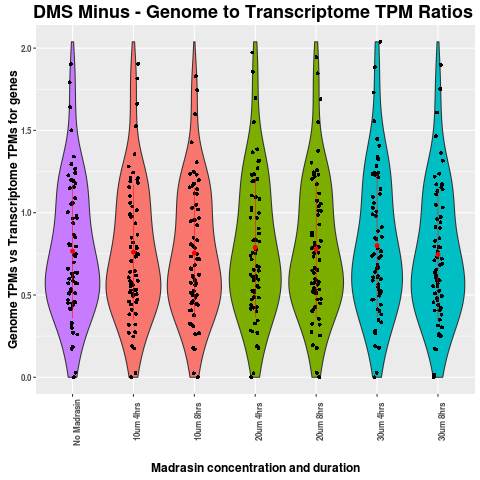

In [17]:
%%R -i ratios_readCounts,numFeatures,removeNC_string,feature,featuresWithIntrons_string
data=ratios_readCounts
data$ID = row.names(data)
melted_data <- melt(data, id=c("ID"))
#tail(melted_data)
p <- ggplot(melted_data, aes(x=variable, y=value,fill=variable)) +
    #geom_boxplot() + 
    geom_violin(trim=FALSE) +
    geom_jitter(shape=16, position=position_jitter(0.2)) + 
    stat_summary(fun.y = mean,fun.ymin = function(x) mean(x) - sd(x),fun.ymax = function(x) mean(x) + sd(x),geom = "pointrange", size=0.25, color="red") +
    theme(axis.title.x=element_text(face="bold",size=12),axis.title.y=element_text(face="bold",size=12),
          axis.text.x = element_text(angle = 90, face="bold",size=8),axis.text.y = element_text(face="bold",size=8),
         legend.position="none",plot.title = element_text(face="bold",size=18)) + 
    #theme_bw() +
    scale_fill_manual(values=c("#C77CFF","#F8766D", "#F8766D","#7CAE00","#7CAE00", "#00BFC4","#00BFC4")) +
    xlab("\nMadrasin concentration and duration") +
    ylab("Genome TPMs vs Transcriptome TPMs for genes") +
    scale_x_discrete(labels=c("No Madrasin","10um 4hrs", "10um 8hrs", "20um 4hrs","20um 8hrs","30um 4hrs","30um 8hrs")) +
    ggtitle("DMS Minus - Genome to Transcriptome TPM Ratios ")
p

In [ ]:
sns.set(font_scale=1)
ratios_readCounts_matrix = ratios_readCounts.values
ax = sns.tsplot(data=ratios_readCounts_matrix,estimator=np.median,interpolate=False, ci="sd")
labels_xaxis = list(ratios_readCounts_avg.index.values)
labels_xaxis.insert(0,"")
print labels_xaxis
ax.set_xticklabels(labels=labels_xaxis,rotation=90)
#plt.ylim(0, 0.5)
plt.tight_layout()
plt.title("Median ratio of transcriptome Vs genomic reads")
plt.savefig("../results/FeatureCounts_MedianRatio_TranscriptomeVsGenomicReads_MinusDMS_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")

In [ ]:
sns.set(font_scale=1)
ratios_readCounts_matrix = ratios_readCounts.values
ax = sns.tsplot(data=ratios_readCounts_matrix,estimator=np.mean,interpolate=False, ci="sd")
labels_xaxis = list(ratios_readCounts_avg.index.values)
labels_xaxis.insert(0,"")
print labels_xaxis
ax.set_xticklabels(labels=labels_xaxis,rotation=90)
#plt.ylim(0, 0.6)
plt.tight_layout()
plt.title("Average ratio of transcriptome Vs genomic reads")
plt.savefig("../results/FeatureCounts_MeanRatio_TranscriptomeVsGenomicReads_MinusDMS_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")

In [ ]:
sns.set(font_scale=4)
ax = sns.clustermap(ratios_readCounts,cmap=sns.light_palette("blue"),annot=False, square=False, yticklabels=True, figsize=(75,75))
ax.savefig("../results/FeatureCounts_Ratio_TranscriptomeVsGenomicReads_MinusDMS_HeatMap_Clustered_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")
reordered_indices = ax.dendrogram_row.reordered_ind

In [ ]:
labels_indices_org = ratios_readCounts.index.values
labels_indices_reordered = labels_indices_org[reordered_indices]
# Reorder the feature counts indices 
ratios_readCounts= ratios_readCounts.reindex(labels_indices_reordered)

In [ ]:
sns.set(font_scale=4)
fig, ax = plt.subplots(figsize=(100,100))
#sns.heatmap(ratios_readCounts_DMS,cmap="RdBu_r",vmax=1,vmin=0,yticklabels=True,center=0.5, ax=ax)
sns.heatmap(ratios_readCounts,cmap=sns.light_palette("blue"),yticklabels=True,annot=ratios_readCounts.values, ax=ax,center=0.2)
plt.savefig("../results/FeatureCounts_Ratio_TranscriptomeVsGenomicReads_MinusDMS_HeatMap_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")

In [19]:
sorted_columns = sorted(list(ratios_readCounts.columns.values))
sorted_columns_NoControl = [i for i in sorted_columns if "All" not in i]

In [20]:
ratios_readCounts_JustMadrasin = ratios_readCounts[sorted_columns_NoControl]
print ratios_readCounts_JustMadrasin.shape
ratios_readCounts_JustMadrasin.head()

(65, 6)


,Mad-10mm-4hr-minus_S4,Mad-10mm-8hr-minus_S10,Mad-20mm-4hr-minus_S5,Mad-20mm-8hr-minus_S11,Mad-30mm-4hr-minus_S6,Mad-30mm-8hr-DMS_S9
ACTB,1.356118,1.307304,1.385162,1.377229,1.407204,1.316689
ACTG1,1.815526,1.744397,1.856713,1.846996,1.884500,1.752027
ATP5F1B,0.586124,0.570749,0.608166,0.595787,0.609858,0.570125
B2M,1.102112,1.143447,1.190918,1.117375,1.230879,1.140980
CALR,0.818606,0.785130,0.837988,0.829251,0.853231,0.794542


In [21]:
# Let's get ratios of feature counts for Madrasin vs non Madrasin
ratiosToControl_readCounts = ratios_readCounts_JustMadrasin.divide(ratios_readCounts["All_Minusfiles"],axis=0)
print ratiosToControl_readCounts.shape
ratiosToControl_readCounts.head()

(65, 6)


,Mad-10mm-4hr-minus_S4,Mad-10mm-8hr-minus_S10,Mad-20mm-4hr-minus_S5,Mad-20mm-8hr-minus_S11,Mad-30mm-4hr-minus_S6,Mad-30mm-8hr-DMS_S9
ACTB,1.011158,0.974760,1.032813,1.026899,1.049248,0.981758
ACTG1,1.012680,0.973004,1.035653,1.030233,1.051152,0.977260
ATP5F1B,1.004588,0.978236,1.042368,1.021150,1.045267,0.977167
B2M,0.952620,0.988349,1.029380,0.965813,1.063921,0.986216
CALR,1.011410,0.970050,1.035356,1.024563,1.054190,0.981678


In [16]:
# Lets the average for every time point and concentration
ratios_readCounts_avg = ratiosToControl_readCounts.apply(np.median,axis=0)
ratios_readCounts_avg

Mad-10mm-4hr-minus_S4     0.996727
Mad-10mm-8hr-minus_S10    0.977432
Mad-20mm-4hr-minus_S5     1.033261
Mad-20mm-8hr-minus_S11    1.013760
Mad-30mm-4hr-minus_S6     1.045240
Mad-30mm-8hr-DMS_S9       0.967713
dtype: float64

/usr/local/lib/python2.7/dist-packages/seaborn-0.8.1-py2.7.egg/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


['', 'Mad-10mm-4hr-minus_S4', 'Mad-10mm-8hr-minus_S10', 'Mad-20mm-4hr-minus_S5', 'Mad-20mm-8hr-minus_S11', 'Mad-30mm-4hr-minus_S6', 'Mad-30mm-8hr-DMS_S9']


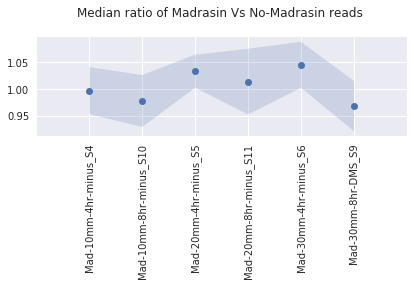

In [17]:
sns.set(font_scale=1)
ratios_readCounts_matrix = ratiosToControl_readCounts.values
ax = sns.tsplot(data=ratios_readCounts_matrix,estimator=np.median,interpolate=False, ci="sd")
labels_xaxis = list(ratios_readCounts_avg.index.values)
labels_xaxis.insert(0,"")
print labels_xaxis
ax.set_xticklabels(labels=labels_xaxis,rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.title("Median ratio of Madrasin Vs No-Madrasin reads \n")
plt.savefig("../results/FeatureCounts_MedianRatioUsingControls_TranscriptomeVsGenomicReads_MinusDMS_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")

[1] "../results/GGplot2-FeatureCounts_MeanRatioUsingControls_TranscriptomeVsGenomicReads_MinusDMS_50MostHighlyExpressedGenesWithIntronicRegions.png"


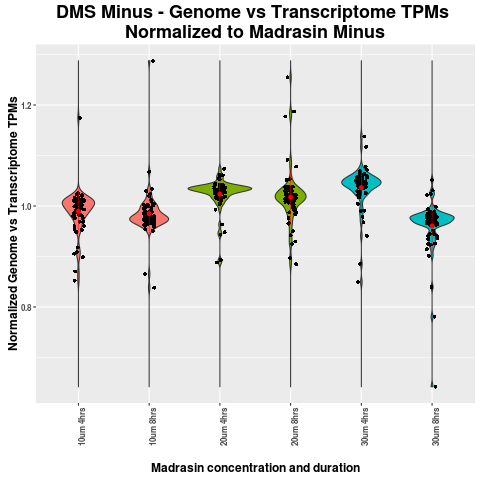

In [27]:
%%R -i ratiosToControl_readCounts,numFeatures,removeNC_string,feature,featuresWithIntrons_string
data=ratiosToControl_readCounts
data$ID = row.names(data)
melted_data <- melt(data, id=c("ID"))
#tail(melted_data)
p <- ggplot(melted_data, aes(x=variable, y=value,fill=variable)) +
    #geom_boxplot() + 
    geom_violin(trim=FALSE) +
    geom_jitter(shape=16, position=position_jitter(0.2)) + 
    stat_summary(fun.y = mean,fun.ymin = function(x) mean(x) - sd(x),fun.ymax = function(x) mean(x) + sd(x),geom = "pointrange", size=0.25, color="red") +
    theme(axis.title.x=element_text(face="bold",size=12),axis.title.y=element_text(face="bold",size=12),
          axis.text.x = element_text(angle = 90, face="bold",size=8),axis.text.y = element_text(face="bold",size=8),
         legend.position="none",plot.title = element_text(face="bold",size=18)) + 
    #theme_bw() +
    scale_fill_manual(values=c("#F8766D", "#F8766D","#7CAE00","#7CAE00", "#00BFC4","#00BFC4")) +
    xlab("\nMadrasin concentration and duration") +
    ylab("Normalized Genome vs Transcriptome TPMs") +
    scale_x_discrete(labels=c("10um 4hrs", "10um 8hrs", "20um 4hrs","20um 8hrs","30um 4hrs","30um 8hrs")) +
    ggtitle("DMS Minus - Genome vs Transcriptome TPMs \n Normalized to Madrasin Minus ")
filenameToSave = paste("../results/GGplot2-FeatureCounts_MeanRatioUsingControls_TranscriptomeVsGenomicReads_MinusDMS_",numFeatures,"MostHighlyExpressed",removeNC_string,feature,"s",featuresWithIntrons_string,".png",sep="")
print(filenameToSave)
ggsave(p,file=filenameToSave,width=8.1,height=5.6,dpi=300)
p

['', 'Mad-10mm-4hr-minus_S4', 'Mad-10mm-8hr-minus_S10', 'Mad-20mm-4hr-minus_S5', 'Mad-20mm-8hr-minus_S11', 'Mad-30mm-4hr-minus_S6', 'Mad-30mm-8hr-DMS_S9']


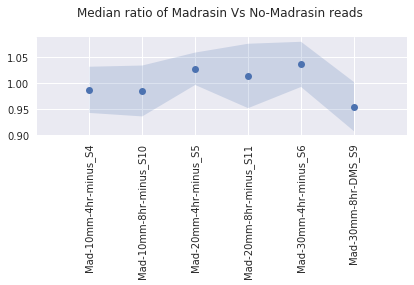

In [18]:
sns.set(font_scale=1)
ratios_readCounts_matrix = ratiosToControl_readCounts.values
ax = sns.tsplot(data=ratios_readCounts_matrix,estimator=np.mean,interpolate=False, ci="sd")
labels_xaxis = list(ratios_readCounts_avg.index.values)
labels_xaxis.insert(0,"")
print labels_xaxis
ax.set_xticklabels(labels=labels_xaxis,rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.title("Median ratio of Madrasin Vs No-Madrasin reads \n")
plt.savefig("../results/FeatureCounts_MeanRatioUsingControls_TranscriptomeVsGenomicReads_MinusDMS_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")

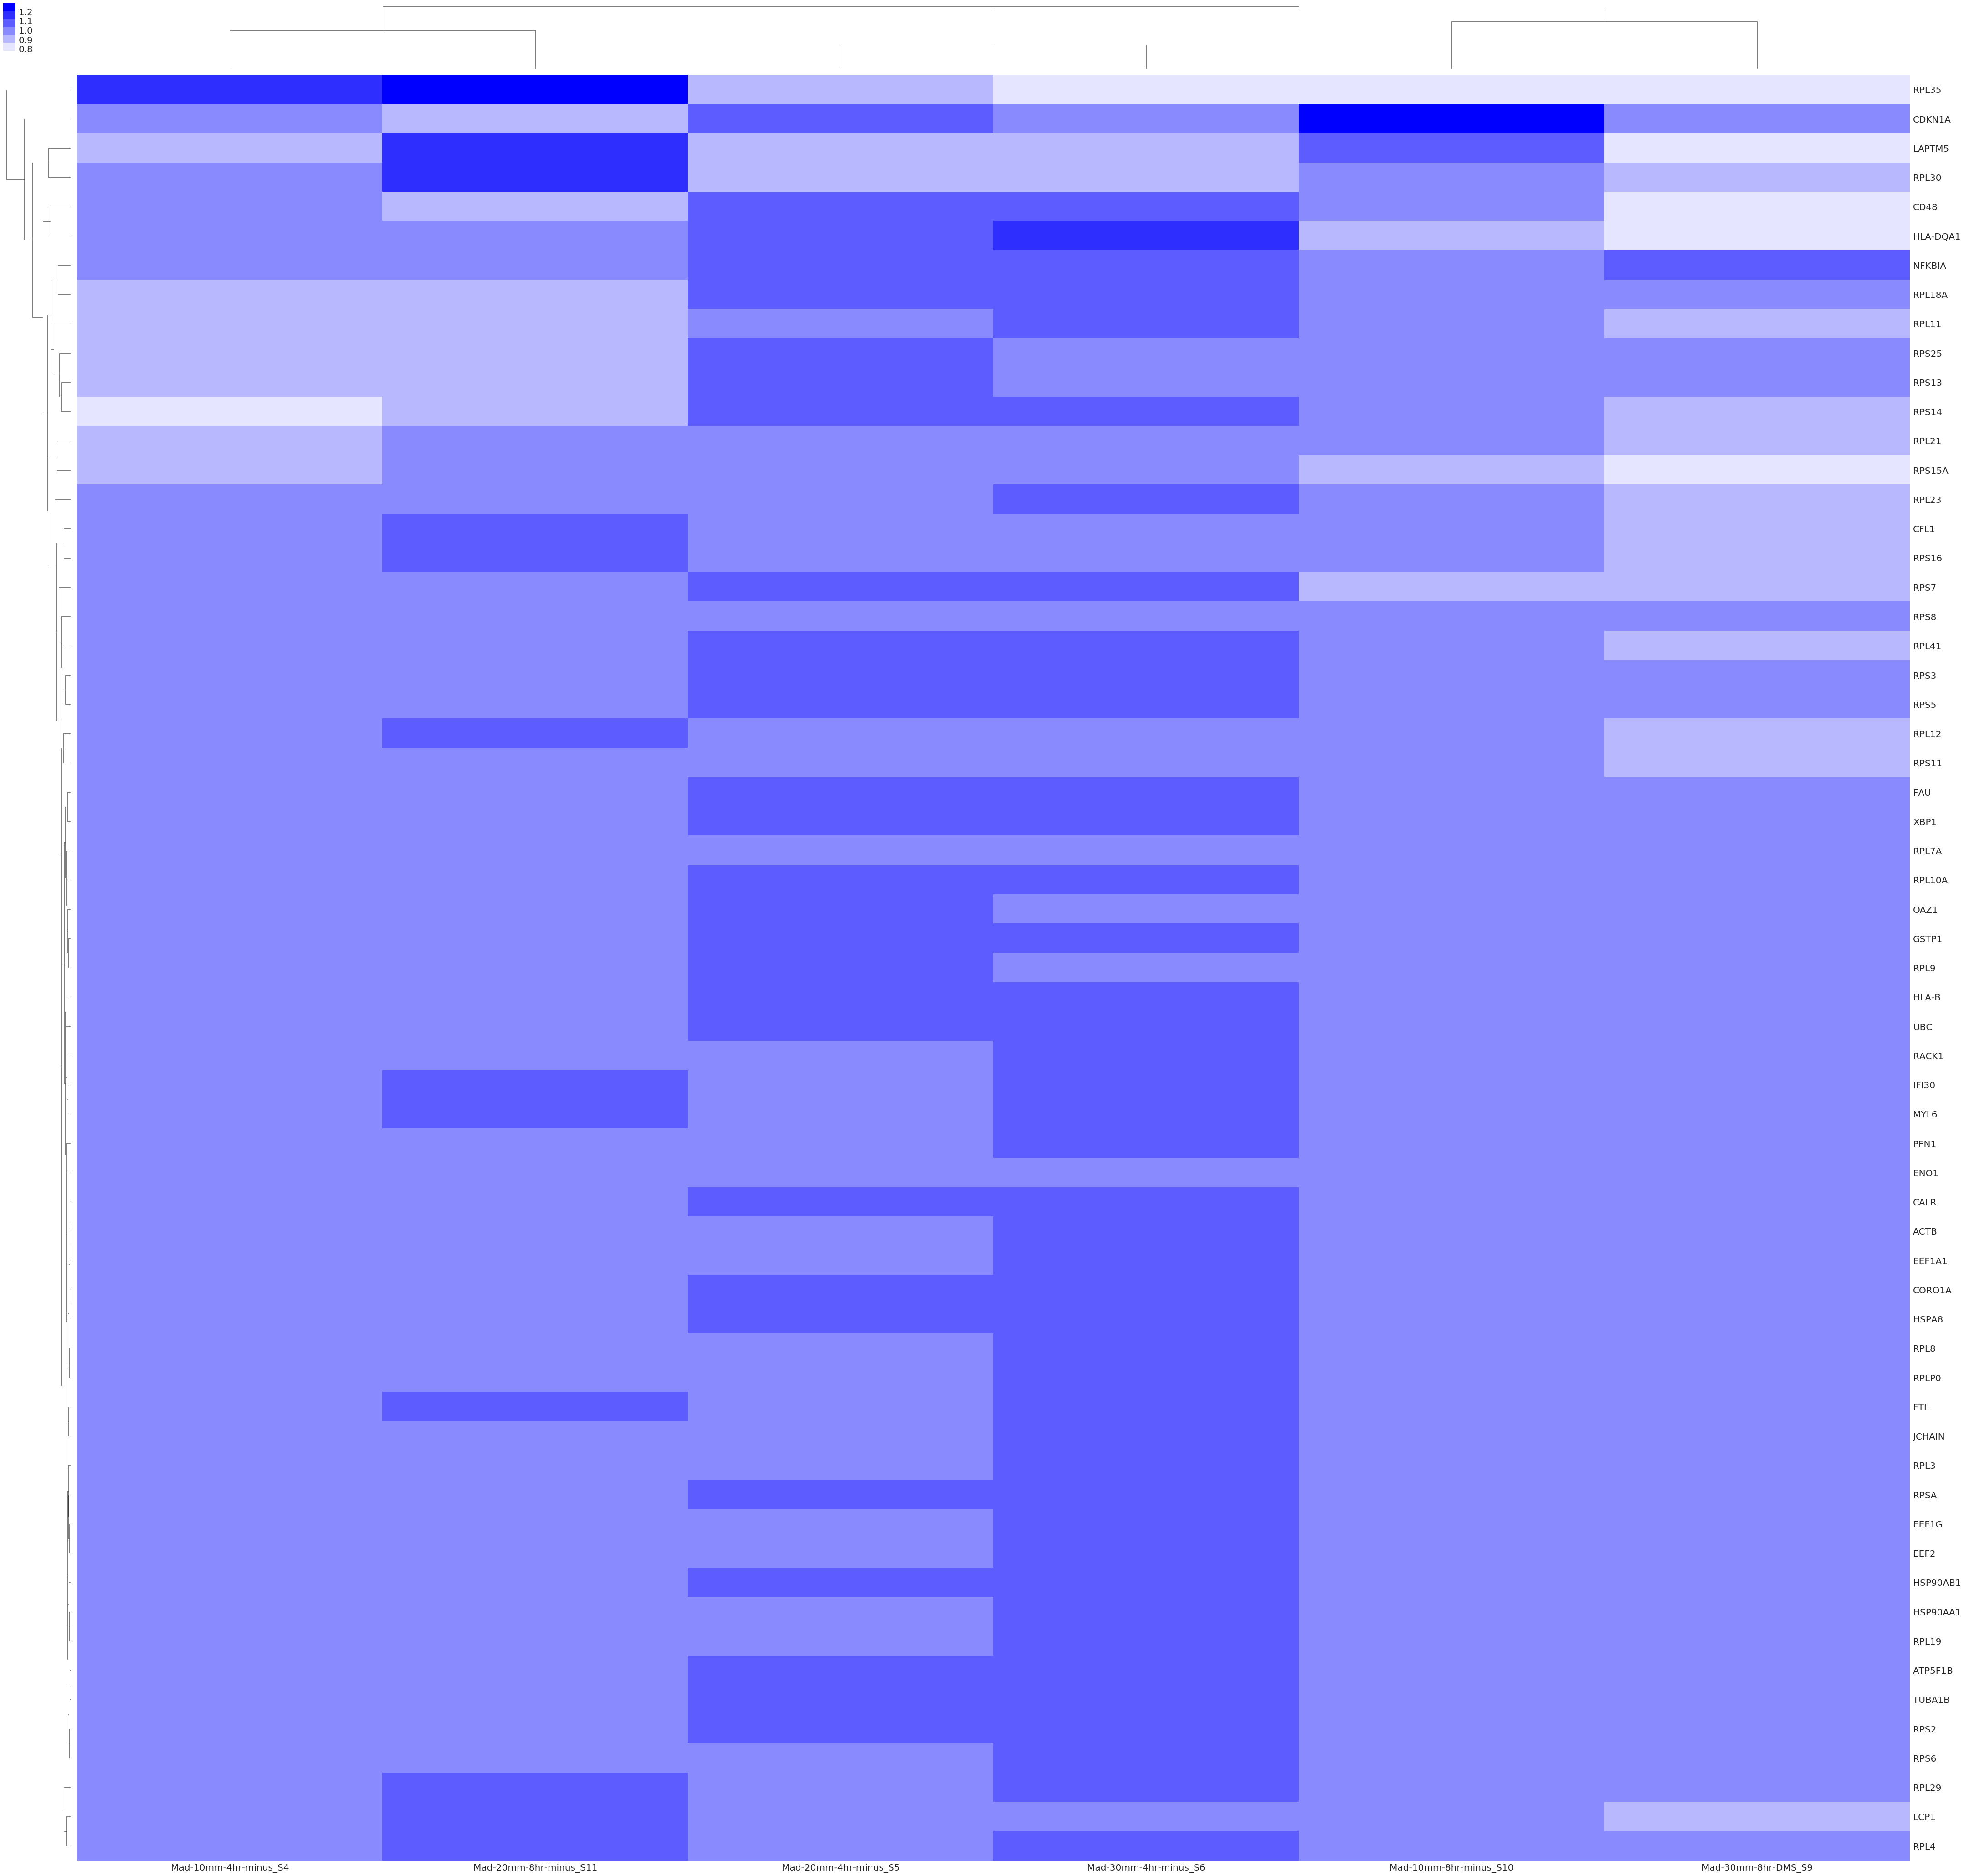

In [19]:
sns.set(font_scale=2)
ax = sns.clustermap(ratiosToControl_readCounts,cmap=sns.light_palette("blue"),annot=False, square=False, yticklabels=True, figsize=(75,75))
ax.savefig("../results/FeatureCounts_RatioUsingControls_TranscriptomeVsGenomicReads_MinusDMS_HeatMap_Clustered_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")
reordered_indices = ax.dendrogram_row.reordered_ind

In [20]:
labels_indices_org = ratiosToControl_readCounts.index.values
labels_indices_reordered = labels_indices_org[reordered_indices]
# Reorder the feature counts indices 
ratiosToControl_readCounts= ratiosToControl_readCounts.reindex(labels_indices_reordered)

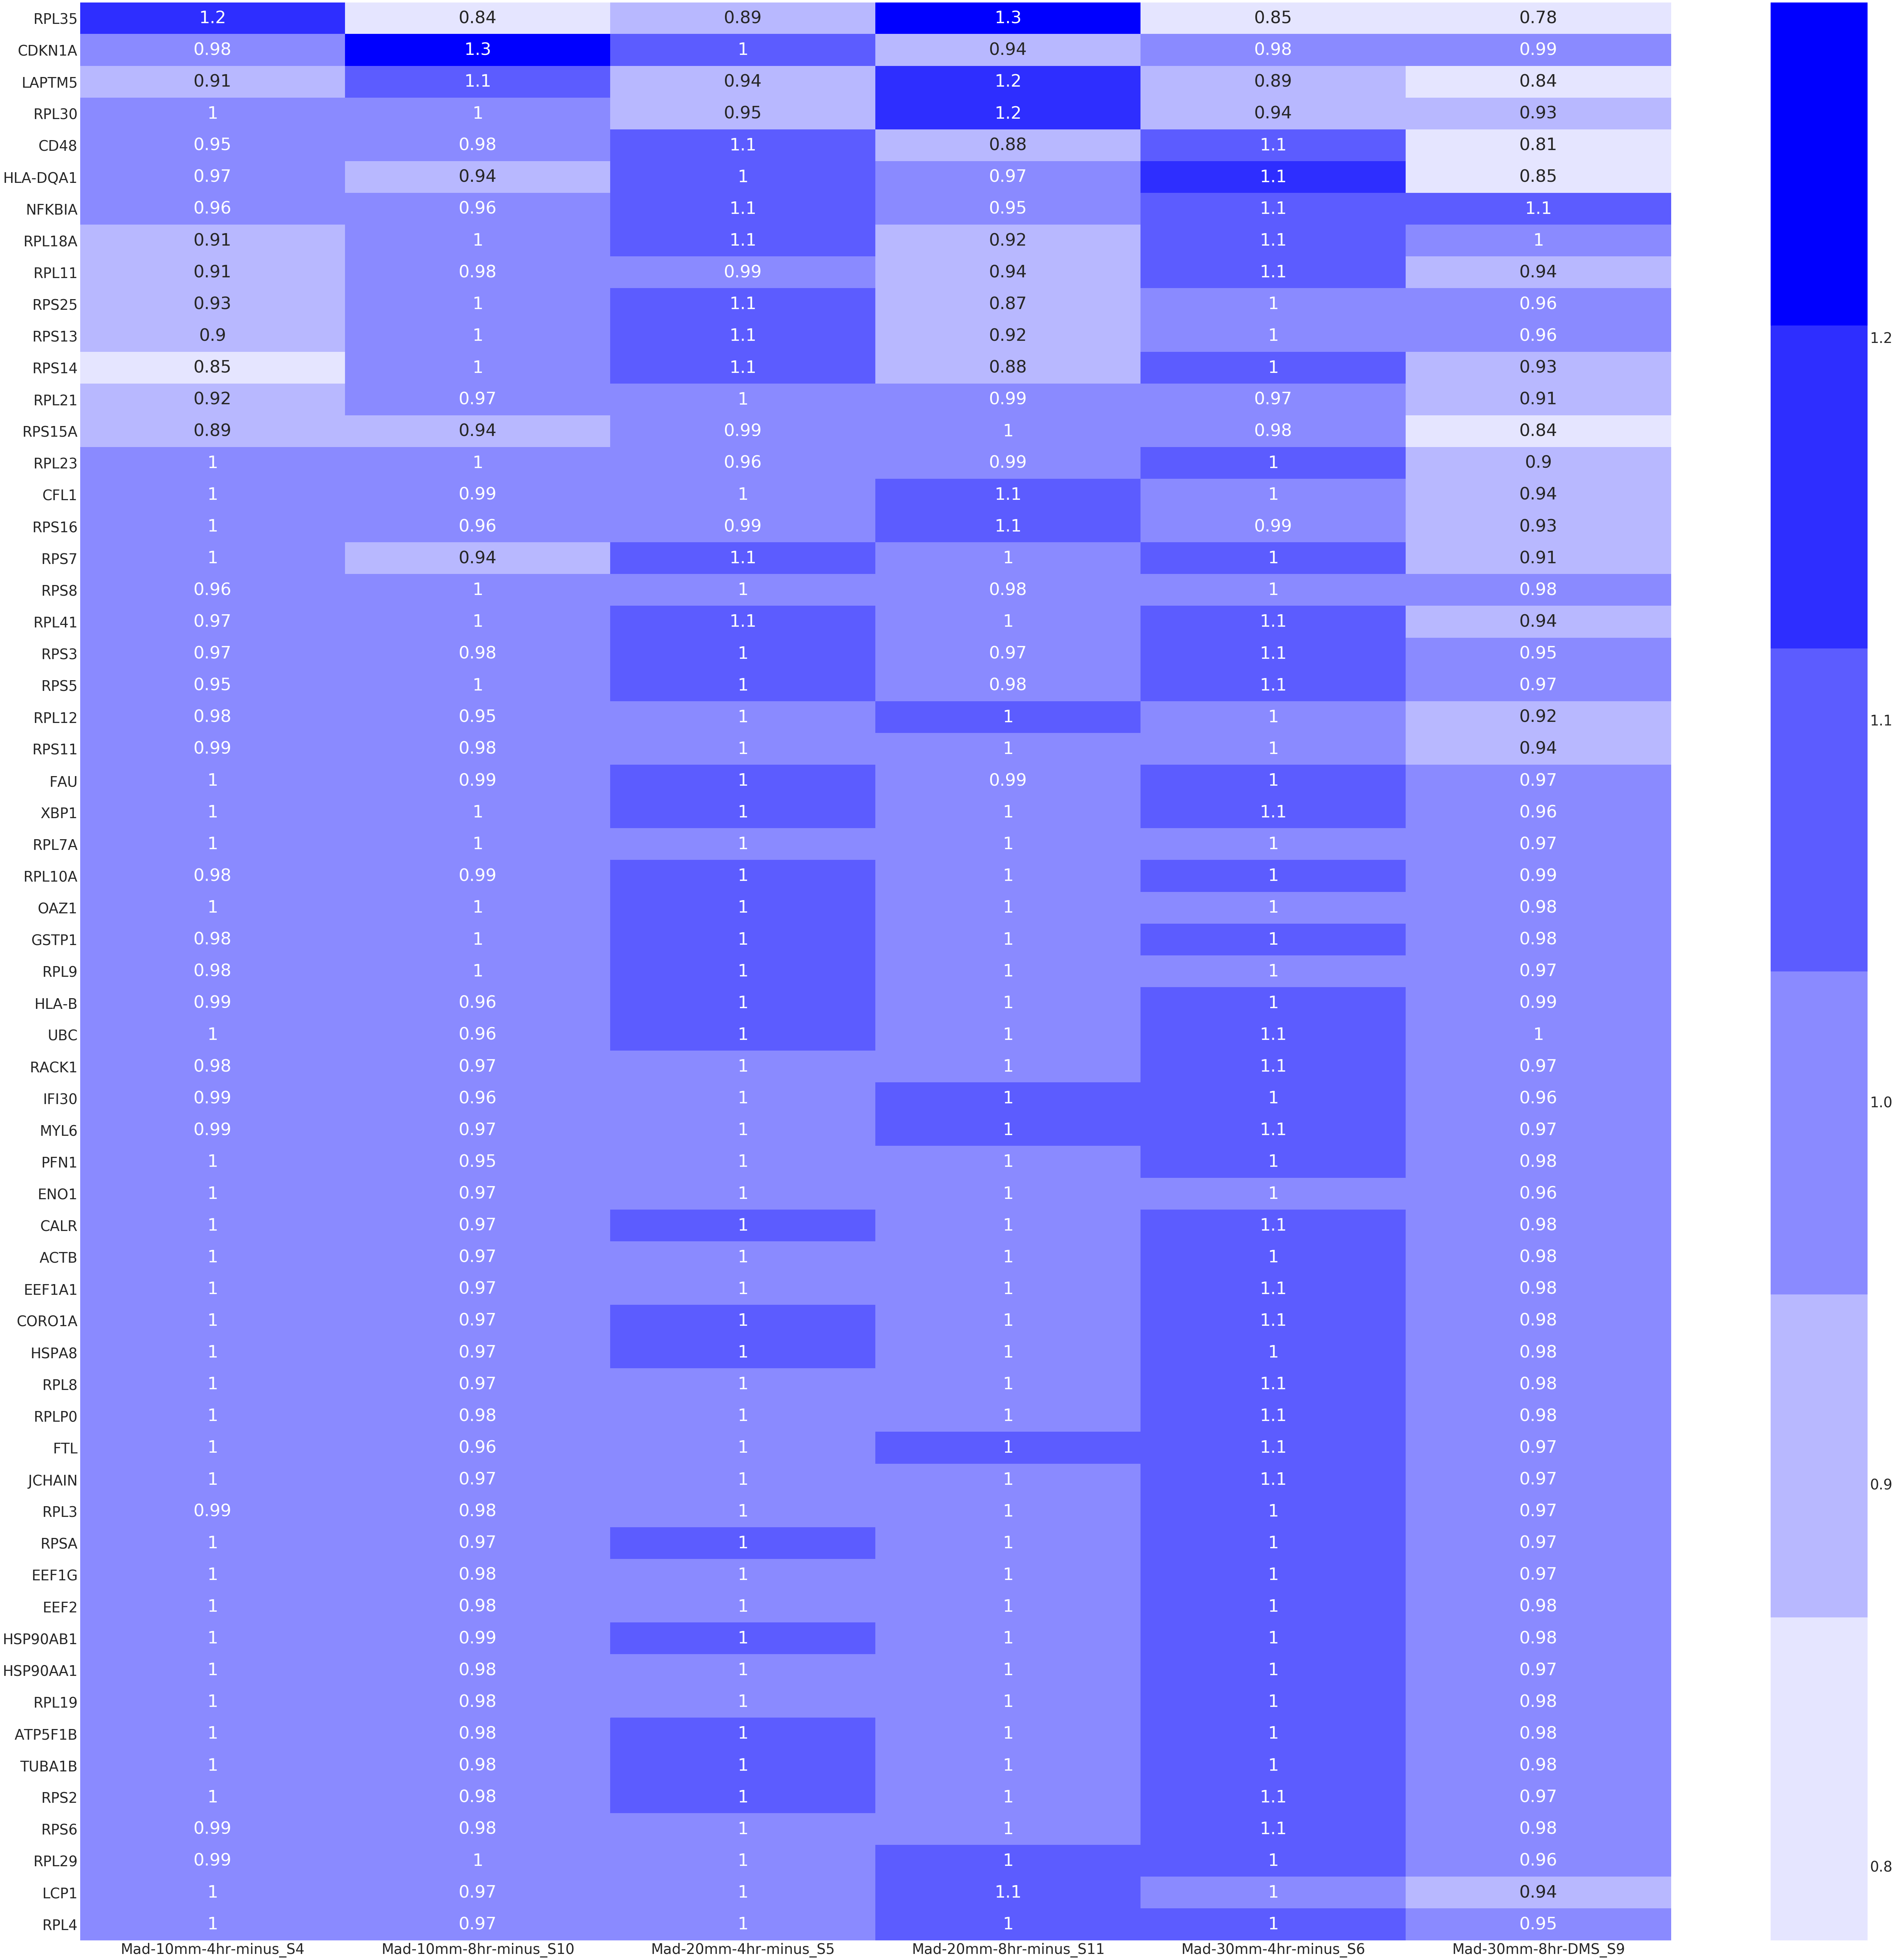

In [21]:
sns.set(font_scale=4)
fig, ax = plt.subplots(figsize=(100,100))
#sns.heatmap(ratios_readCounts_DMS,cmap="RdBu_r",vmax=1,vmin=0,yticklabels=True,center=0.5, ax=ax)
sns.heatmap(ratiosToControl_readCounts,cmap=sns.light_palette("blue"),yticklabels=True,annot=ratiosToControl_readCounts.values, ax=ax)#,center=0.2)
plt.savefig("../results/FeatureCounts_RatioUsingControls_TranscriptomeVsGenomicReads_MinusDMS_HeatMap_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")